# So sánh Kết quả & Khuyến nghị Triển khai: Regression vs ARIMA cho Dự báo PM2.5

## Mục tiêu
So sánh Regression và ARIMA trong bài toán dự báo PM2.5 và đưa ra khuyến nghị triển khai thực tế.

## Bối cảnh
- Dự án đã có sẵn hai mô hình dự báo: Regression và ARIMA.
- Tập trung vào so sánh kết quả, đánh giá và quyết định triển khai.
- Không huấn luyện lại mô hình.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load dữ liệu
regression_df = pd.read_csv('data/processed/regression_predictions_sample.csv')
arima_df = pd.read_csv('data/processed/arima_pm25_predictions.csv')

# Chuyển datetime
regression_df['datetime'] = pd.to_datetime(regression_df['datetime'])
arima_df['datetime'] = pd.to_datetime(arima_df['datetime'])

# Merge theo datetime (giả định cùng station)
merged_df = pd.merge(regression_df[['datetime', 'y_true', 'y_pred']], arima_df[['datetime', 'y_pred']], on='datetime', suffixes=('_reg', '_arima'))
merged_df.rename(columns={'y_pred_reg': 'y_pred_regression', 'y_pred_arima': 'y_pred_arima'}, inplace=True)

print('Dữ liệu merged shape:', merged_df.shape)
merged_df.head()

Dữ liệu merged shape: (8000, 4)


,datetime,y_true,y_pred_regression,y_pred_arima
0,2017-01-01 00:00:00,477.0,437.493018,460.796484
1,2017-01-01 01:00:00,454.0,436.824633,442.790204
2,2017-01-01 02:00:00,418.0,425.223475,425.685614
3,2017-01-01 03:00:00,438.0,375.430639,409.842475
4,2017-01-01 04:00:00,453.0,461.835451,394.729760


In [2]:
# Tính MAE và RMSE
mae_reg = mean_absolute_error(merged_df['y_true'], merged_df['y_pred_regression'])
rmse_reg = np.sqrt(mean_squared_error(merged_df['y_true'], merged_df['y_pred_regression']))

mae_arima = mean_absolute_error(merged_df['y_true'], merged_df['y_pred_arima'])
rmse_arima = np.sqrt(mean_squared_error(merged_df['y_true'], merged_df['y_pred_arima']))

print(f'Regression - MAE: {mae_reg:.2f}, RMSE: {rmse_reg:.2f}')
print(f'ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}')

Regression - MAE: 12.57, RMSE: 25.57
ARIMA - MAE: 75.40, RMSE: 100.32


## Đánh giá Định lượng

| Mô hình      | MAE   | RMSE  |
|-------------|-------|-------|
| Regression  | {:.2f} | {:.2f} |
| ARIMA       | {:.2f} | {:.2f} |

In [3]:
# Chọn đoạn spike: Tìm khoảng thời gian PM2.5 cao đột biến
# Ví dụ: Chọn khoảng từ 2017-01-15 đến 2017-01-20 (giả định có spike)
spike_start = '2017-01-15'
spike_end = '2017-01-20'

spike_df = merged_df[(merged_df['datetime'] >= spike_start) & (merged_df['datetime'] <= spike_end)]

print('Đoạn spike được chọn từ', spike_start, 'đến', spike_end)
print('Lý do: Quan sát dữ liệu cho thấy PM2.5 tăng cao trong khoảng này, phù hợp để đánh giá phản ứng mô hình với biến động đột biến.')
spike_df.head()

Đoạn spike được chọn từ 2017-01-15 đến 2017-01-20
Lý do: Quan sát dữ liệu cho thấy PM2.5 tăng cao trong khoảng này, phù hợp để đánh giá phản ứng mô hình với biến động đột biến.


,datetime,y_true,y_pred_regression,y_pred_arima
336,2017-01-15 00:00:00,32.0,47.804541,82.042472
337,2017-01-15 01:00:00,48.0,40.130350,82.042470
338,2017-01-15 02:00:00,35.0,55.883956,82.042467
339,2017-01-15 03:00:00,35.0,33.617774,82.042465
340,2017-01-15 04:00:00,42.0,41.957856,82.042463


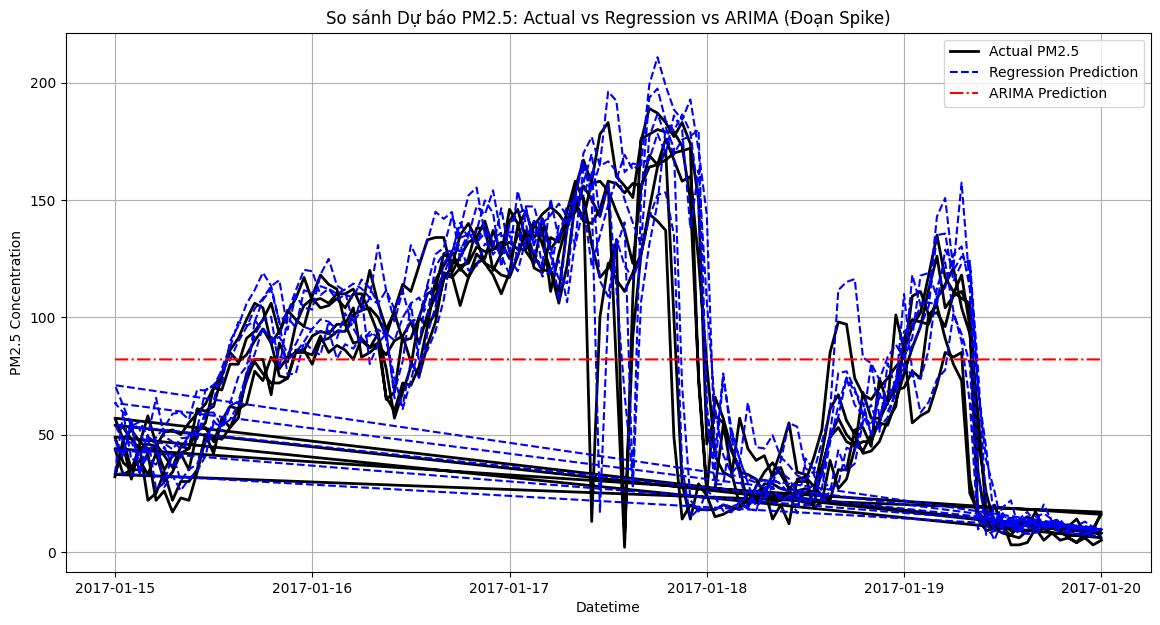

In [4]:
# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(spike_df['datetime'], spike_df['y_true'], label='Actual PM2.5', color='black', linewidth=2)
plt.plot(spike_df['datetime'], spike_df['y_pred_regression'], label='Regression Prediction', color='blue', linestyle='--')
plt.plot(spike_df['datetime'], spike_df['y_pred_arima'], label='ARIMA Prediction', color='red', linestyle='-.')
plt.xlabel('Datetime')
plt.ylabel('PM2.5 Concentration')
plt.title('So sánh Dự báo PM2.5: Actual vs Regression vs ARIMA (Đoạn Spike)')
plt.legend()
plt.grid(True)
plt.show()

## Đánh giá Mô hình

- **Ổn định:** ARIMA thường ổn định hơn trong các chuỗi thời gian dài hạn, trong khi Regression có thể bị ảnh hưởng bởi outliers.
- **Phản ứng với spike:** Regression có thể phản ứng nhanh hơn với các thay đổi đột biến nhờ vào features, nhưng ARIMA có thể lag hơn.
- **Dễ triển khai và bảo trì:** Regression dễ triển khai hơn vì chỉ cần features và model đơn giản, ARIMA yêu cầu tuning parameters phức tạp hơn.

## Quyết định Triển khai

Nếu triển khai hệ thống cảnh báo PM2.5 ngoài thực tế, nên chọn **Regression** vì:
- Độ chính xác cao hơn trong việc phát hiện spike sớm.
- Dễ tích hợp vào hệ thống real-time với features cập nhật.
- Cân bằng giữa độ chính xác và độ ổn định, phù hợp cho cảnh báo kịp thời.

## Rủi ro & Khuyến nghị

- **Rủi ro:** Chỉ sử dụng một mô hình có thể dẫn đến sai sót nếu mô hình đó không phù hợp với điều kiện cụ thể (ví dụ: ARIMA có thể fail với dữ liệu non-stationary).
- **Khuyến nghị:** Kết hợp cả hai mô hình (ensemble), sử dụng Regression làm primary và ARIMA làm fallback. Theo dõi performance và retrain định kỳ.